<a href="https://colab.research.google.com/github/kaylynrmd/Predictive-Analytics-Project/blob/main/notebooks/04_modeling_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Baseline Model: Logistic Regression

This notebook builds a baseline predictive model to estimate customer churn.
Logistic Regression is used as a baseline because it is:
- Interpretable
- Fast to train
- Commonly used for binary classification problems like churn

The model is evaluated using classification metrics and ROC-AUC.


In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    RocCurveDisplay
)
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
import kagglehub
import os

path = kagglehub.dataset_download("blastchar/telco-customer-churn")
files = os.listdir(path)
df = pd.read_csv(os.path.join(path, files[0]))

df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

if "customerID" in df.columns:
    df = df.drop(columns=["customerID"])

df.head()


Using Colab cache for faster access to the 'telco-customer-churn' dataset.


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
X = df.drop(columns=["Churn"])
y = df["Churn"].map({"Yes": 1, "No": 0})

y.value_counts(normalize=True)


,proportion
Churn,
0,0.73463
1,0.26537


In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)


In [6]:
cat_cols = X_train.select_dtypes(include=["object"]).columns
num_cols = X_train.select_dtypes(exclude=["object"]).columns

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols)
    ]
)


In [7]:
log_reg_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter=1000))
])

log_reg_model


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod'],
      dtype='object'))])),
                ('classifier', LogisticRegression(max_iter=1000))])

In [8]:
log_reg_model.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod'],
      dtype='object'))])),
                ('classifier', LogisticRegression(max_iter=1000))])

In [9]:
y_pred = log_reg_model.predict(X_test)
y_prob = log_reg_model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1035
           1       0.66      0.56      0.60       374

    accuracy                           0.81      1409
   macro avg       0.75      0.73      0.74      1409
weighted avg       0.80      0.81      0.80      1409



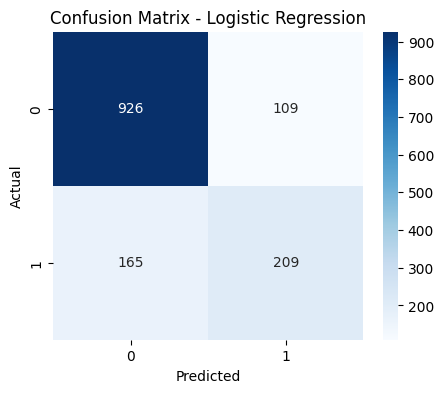

In [10]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [11]:
roc_auc = roc_auc_score(y_test, y_prob)
roc_auc


np.float64(0.8418610659019866)

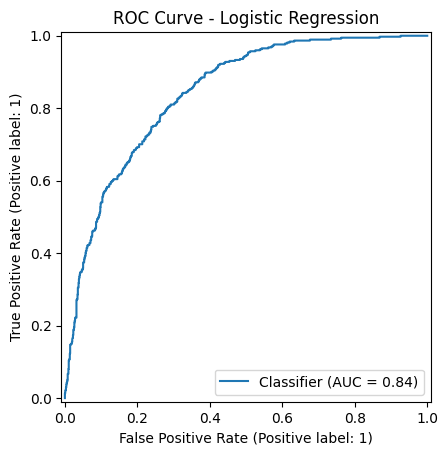

In [12]:
RocCurveDisplay.from_predictions(y_test, y_prob)
plt.title("ROC Curve - Logistic Regression")
plt.show()


In [ ]:
## Model Performance Interpretation

The logistic regression model provides a solid baseline for predicting customer churn.

- The ROC-AUC score indicates the model is better than random guessing.
- Recall is especially important in this problem, as failing to identify a customer who will churn is costly.
- The confusion matrix shows that while the model correctly classifies many non-churn customers, it struggles more with identifying churners.

These results suggest that a more flexible, non-linear model may improve performance.


In [ ]:
## Business Implications

As a baseline model, logistic regression offers interpretability but limited predictive power.
The results suggest that:
- Early identification of high-risk customers is possible
- However, additional modeling techniques may capture more complex churn patterns
- Improving recall would help target retention efforts more effectively
